# Glacier Monitoring Results Visualization

This notebook visualizes the results from the glacier monitoring algorithm.
It displays processed grid cells, snow/ice coverage, and NDSI tiles on an interactive map.

In [40]:
# Install required packages if needed
# !pip install folium geopandas rasterio matplotlib

In [9]:
import json
import glob
from pathlib import Path

import pandas as pd
import geopandas as gpd
import folium
from folium import plugins
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# For reading NDSI tiles
try:
    import rasterio
    from rasterio.plot import show
    HAS_RASTERIO = True
except ImportError:
    HAS_RASTERIO = False
    print("rasterio not installed - NDSI tile visualization will be limited")

## 1. Configure Output Directory

Set the path to your output directory containing the results.

In [10]:
# Set your output directory here
OUTPUT_DIR = Path("output/test_old")

# Find the most recent results files
grid_files = sorted(OUTPUT_DIR.glob("processed_grid_*.geojson"))
stats_files = sorted(OUTPUT_DIR.glob("statistics_*.json"))
tile_dir = OUTPUT_DIR / "ndsi_tiles"

if grid_files:
    print(f"Found {len(grid_files)} grid file(s)")
    print(f"  Latest: {grid_files[-1].name}")
else:
    print("No grid files found!")

if stats_files:
    print(f"Found {len(stats_files)} statistics file(s)")
    print(f"  Latest: {stats_files[-1].name}")

if tile_dir.exists():
    tiles = list(tile_dir.glob("*.tif"))
    print(f"Found {len(tiles)} NDSI tile(s)")

Found 1 grid file(s)
  Latest: processed_grid_20260128_223350.geojson
Found 1 statistics file(s)
  Latest: statistics_20260128_223350.json


## 2. Load Statistics

In [11]:
# Load the latest statistics
if stats_files:
    with open(stats_files[-1]) as f:
        stats = json.load(f)
    
    print("=" * 60)
    print("PROCESSING STATISTICS")
    print("=" * 60)
    
    # Configuration
    config = stats.get('configuration', {})
    print(f"\nConfiguration:")
    print(f"  Date range:      {config.get('date_start')} to {config.get('date_end')}")
    print(f"  Grid size:       {config.get('grid_size', 10000)} m")
    print(f"  NDSI threshold:  {config.get('ndsi_threshold', 0.42)}")
    print(f"  Snow threshold:  {config.get('snow_percentage_threshold', 0.30) * 100}%")
    
    # Results
    results = stats.get('results', {})
    print(f"\nResults:")
    print(f"  Cells processed:   {results.get('total_cells_processed', 0)}")
    print(f"  Initial candidates: {results.get('initial_candidates', 0)}")
    print(f"  Expansion adds:    {results.get('expansion_added_cells', 0)}")
    print(f"  Iterations:        {results.get('iterations', 0)}")
    print(f"  Snow/Ice area:     {results.get('snow_ice_coverage_km2', 0):.2f} km²")
    print(f"  Total area:        {results.get('total_valid_area_km2', 0):.2f} km²")
    print(f"  Snow/Ice %:        {results.get('snow_ice_percentage', 0):.2f}%")
    print(f"  Processing time:   {results.get('processing_time_formatted', 'N/A')}")
    print("=" * 60)
else:
    print("No statistics files found!")
    stats = {}

PROCESSING STATISTICS

Configuration:
  Date range:      2025-07-01 to 2025-07-31
  Grid size:       10000 m
  NDSI threshold:  0.42
  Snow threshold:  30.0%

Results:
  Cells processed:   40
  Initial candidates: 1
  Expansion adds:    39
  Iterations:        10
  Snow/Ice area:     823.54 km²
  Total area:        1864.26 km²
  Snow/Ice %:        44.18%
  Processing time:   N/A


## 3. Load Processed Grid

In [12]:
# Load the processed grid
if grid_files:
    grid = gpd.read_file(grid_files[-1])
    print(f"✓ Loaded grid with {len(grid)} processed cells")
    print(f"  CRS: {grid.crs}")
    print(f"  Columns: {list(grid.columns)}")
    
    # Convert snow_percentage to numeric (may be stored as string)
    if 'snow_percentage' in grid.columns:
        grid['snow_percentage'] = pd.to_numeric(grid['snow_percentage'], errors='coerce')
    
    # Separate initial cells (with seeds) from expansion cells
    # This matches the structure in icland_ice_monitoring.ipynb
    if 'seed_count' in grid.columns:
        initial_cells_gdf = grid[grid['seed_count'] > 0]
        expansion_cells_gdf = grid[grid['seed_count'] == 0]
        print(f"\nProcessed cells by origin:")
        print(f"  Initial (with seeds): {len(initial_cells_gdf)}")
        print(f"  Added by expansion:   {len(expansion_cells_gdf)}")
    else:
        initial_cells_gdf = grid
        expansion_cells_gdf = gpd.GeoDataFrame()
        print("  (No seed_count column - all cells treated as initial)")
    
    # Show first few rows
    display(grid.head())
else:
    grid = None
    initial_cells_gdf = None
    expansion_cells_gdf = None
    print("✗ No grid file found!")

✓ Loaded grid with 40 processed cells
  CRS: EPSG:5325
  Columns: ['cell_id', 'is_candidate', 'seed_count', 'is_processed', 'snow_percentage', 'geometry']

Processed cells by origin:
  Initial (with seeds): 1
  Added by expansion:   39


,cell_id,is_candidate,seed_count,is_processed,snow_percentage,geometry
0,803,True,0,True,3.685019,"POLYGON ((1640000 230000, 1640000 240000, 1630..."
1,804,True,0,True,10.625915,"POLYGON ((1650000 230000, 1650000 240000, 1640..."
2,862,True,0,True,9.507787,"POLYGON ((1630000 240000, 1630000 250000, 1620..."
3,863,True,0,True,33.974350,"POLYGON ((1640000 240000, 1640000 250000, 1630..."
4,864,True,0,True,31.478692,"POLYGON ((1650000 240000, 1650000 250000, 1640..."


## 4. Interactive Map - Processed Cells

Shows processed grid cells with color-coded by origin (same as icland_ice_monitoring.ipynb):
- **Blue cells**: Initial candidates (containing seed points)
- **Green cells**: Added by spatial expansion algorithm

> ⚠️ **Note**: The satellite imagery shown is the *current* imagery from the tile provider, 
> NOT from the analysis date range. Snow/ice conditions may differ from when the data was captured.
> Use this map to see the spatial extent of processing, not to validate snow detection accuracy.

In [13]:
# ======================================================================
# Visualization: Interactive Folium Map with Processed Cells
# Same visualization style as icland_ice_monitoring.ipynb
# ======================================================================

if grid is not None and len(grid) > 0:
    # Calculate center BEFORE converting to WGS84 (avoids centroid warning)
    center_point = grid.geometry.union_all().centroid
    center_gdf = gpd.GeoDataFrame(geometry=[center_point], crs=grid.crs)
    center_wgs84 = center_gdf.to_crs(epsg=4326)
    center_lat = center_wgs84.geometry.iloc[0].y
    center_lon = center_wgs84.geometry.iloc[0].x
    
    # Transform to WGS84 for web mapping (folium requires WGS84)
    processed_grid_wgs84 = grid.to_crs(epsg=4326)
    initial_cells_wgs84 = initial_cells_gdf.to_crs(epsg=4326) if len(initial_cells_gdf) > 0 else None
    expansion_cells_wgs84 = expansion_cells_gdf.to_crs(epsg=4326) if len(expansion_cells_gdf) > 0 else None
    
    # Create interactive map with satellite imagery
    map_results = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=8,
        tiles=None
    )
    
    # Add base layers
    folium.TileLayer('OpenStreetMap', name='OpenStreetMap').add_to(map_results)
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri World Imagery',
        name='Satellite Imagery (current, not analysis date)',
        overlay=False,
        control=True
    ).add_to(map_results)
    
    # Add initial cells (with seeds) in BLUE - matches icland_ice_monitoring.ipynb
    if initial_cells_wgs84 is not None and len(initial_cells_wgs84) > 0:
        # Prepare columns for tooltip
        tooltip_cols = ['cell_id']
        if 'seed_count' in initial_cells_wgs84.columns:
            tooltip_cols.append('seed_count')
        if 'snow_percentage' in initial_cells_wgs84.columns:
            tooltip_cols.append('snow_percentage')
        tooltip_cols.append('geometry')
        
        folium.GeoJson(
            initial_cells_wgs84[tooltip_cols],
            name='Initial Cells (with seeds)',
            style_function=lambda x: {
                'fillColor': 'blue',
                'color': 'darkblue',
                'weight': 2.5,
                'fillOpacity': 0.4,
                'opacity': 0.7
            },
            tooltip=folium.GeoJsonTooltip(
                fields=[c for c in tooltip_cols if c != 'geometry'],
                aliases=[c.replace('_', ' ').title() + ':' for c in tooltip_cols if c != 'geometry'],
                localize=True
            )
        ).add_to(map_results)
    
    # Add expansion cells (no seeds) in GREEN - matches icland_ice_monitoring.ipynb
    if expansion_cells_wgs84 is not None and len(expansion_cells_wgs84) > 0:
        tooltip_cols = ['cell_id']
        if 'snow_percentage' in expansion_cells_wgs84.columns:
            tooltip_cols.append('snow_percentage')
        tooltip_cols.append('geometry')
        
        folium.GeoJson(
            expansion_cells_wgs84[tooltip_cols],
            name='Expansion Cells',
            style_function=lambda x: {
                'fillColor': 'lightgreen',
                'color': 'green',
                'weight': 2.5,
                'fillOpacity': 0.4,
                'opacity': 0.7
            },
            tooltip=folium.GeoJsonTooltip(
                fields=[c for c in tooltip_cols if c != 'geometry'],
                aliases=[c.replace('_', ' ').title() + ':' for c in tooltip_cols if c != 'geometry'],
                localize=True
            )
        ).add_to(map_results)
    
    # Add fullscreen button
    plugins.Fullscreen().add_to(map_results)
    
    # Add layer control (collapsed=False matches icland_ice_monitoring.ipynb)
    folium.LayerControl(collapsed=False).add_to(map_results)
    
    # Print summary
    print(f"\n✓ Interactive map created with {len(grid)} processed cells")
    if initial_cells_wgs84 is not None:
        print(f"  🔵 Blue cells: Initial candidates (with seeds) - {len(initial_cells_wgs84)}")
    if expansion_cells_wgs84 is not None:
        print(f"  🟢 Green cells: Added by spatial expansion - {len(expansion_cells_wgs84)}")
    print(f"\n⚠️  Note: Satellite imagery is CURRENT, not from analysis date range!")
    print(f"    Analysis period: {stats.get('configuration', {}).get('date_start', 'N/A')} to {stats.get('configuration', {}).get('date_end', 'N/A')}")
    print(f"\nTip: Use the layer control in the top right to toggle layers on/off")
    
    # Display map
    display(map_results)
else:
    print("No grid data to display. Run the glacier monitoring algorithm first.")


✓ Interactive map created with 40 processed cells
  🔵 Blue cells: Initial candidates (with seeds) - 1
  🟢 Green cells: Added by spatial expansion - 39

⚠️  Note: Satellite imagery is CURRENT, not from analysis date range!
    Analysis period: 2025-07-01 to 2025-07-31

Tip: Use the layer control in the top right to toggle layers on/off


## 5. Snow Coverage Map (Color-coded by percentage)

Alternative view showing cells colored by snow/ice coverage percentage:
- 🔵 **Dark blue**: >50% snow coverage
- 🔷 **Light blue**: 30-50% snow coverage
- 🟡 **Yellow**: 10-30% snow coverage
- 🔴 **Red**: <10% snow coverage
- ⬜ **Gray**: No data

In [14]:
# ======================================================================
# Visualization: Snow Coverage Map (Color-coded by percentage)
# ======================================================================

if grid is not None and len(grid) > 0:
    # Calculate center BEFORE converting to WGS84 (avoids centroid warning)
    center_point = grid.geometry.union_all().centroid
    center_gdf = gpd.GeoDataFrame(geometry=[center_point], crs=grid.crs)
    center_wgs84 = center_gdf.to_crs(epsg=4326)
    center_lat = center_wgs84.geometry.iloc[0].y
    center_lon = center_wgs84.geometry.iloc[0].x
    
    processed_grid_wgs84 = grid.to_crs(epsg=4326)
    
    # Create map
    snow_map = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=8,
        tiles=None
    )
    
    # Add base layers
    folium.TileLayer('OpenStreetMap', name='OpenStreetMap').add_to(snow_map)
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Satellite'
    ).add_to(snow_map)
    
    # Color function based on snow percentage (handles string/numeric/NaN)
    def get_color(snow_pct):
        # Handle None, NaN, or non-numeric values
        if snow_pct is None:
            return '#808080'  # Gray
        try:
            snow_pct = float(snow_pct)
            if np.isnan(snow_pct):
                return '#808080'  # Gray
        except (ValueError, TypeError):
            return '#808080'  # Gray
        
        if snow_pct >= 50:
            return '#0066cc'  # Dark blue
        elif snow_pct >= 30:
            return '#66b3ff'  # Light blue
        elif snow_pct >= 10:
            return '#ffff66'  # Yellow
        else:
            return '#ff6666'  # Red
    
    def style_function(feature):
        snow_pct = feature['properties'].get('snow_percentage')
        return {
            'fillColor': get_color(snow_pct),
            'color': '#000000',
            'weight': 1,
            'fillOpacity': 0.6
        }
    
    # Add grid cells
    folium.GeoJson(
        processed_grid_wgs84.__geo_interface__,
        name='Snow Coverage',
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(
            fields=['cell_id', 'snow_percentage'],
            aliases=['Cell ID:', 'Snow Coverage (%):'],
            localize=True
        )
    ).add_to(snow_map)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; 
                background-color: white; padding: 10px; border: 2px solid gray;
                border-radius: 5px; font-size: 14px;">
        <b>Snow/Ice Coverage</b><br>
        <i style="background: #0066cc; width: 18px; height: 18px; display: inline-block;"></i> >50%<br>
        <i style="background: #66b3ff; width: 18px; height: 18px; display: inline-block;"></i> 30-50%<br>
        <i style="background: #ffff66; width: 18px; height: 18px; display: inline-block;"></i> 10-30%<br>
        <i style="background: #ff6666; width: 18px; height: 18px; display: inline-block;"></i> <10%<br>
        <i style="background: #808080; width: 18px; height: 18px; display: inline-block;"></i> No data
    </div>
    '''
    snow_map.get_root().html.add_child(folium.Element(legend_html))
    
    plugins.Fullscreen().add_to(snow_map)
    folium.LayerControl().add_to(snow_map)
    
    display(snow_map)
else:
    print("No grid data to display.")

## 6. Snow Coverage Distribution Analysis

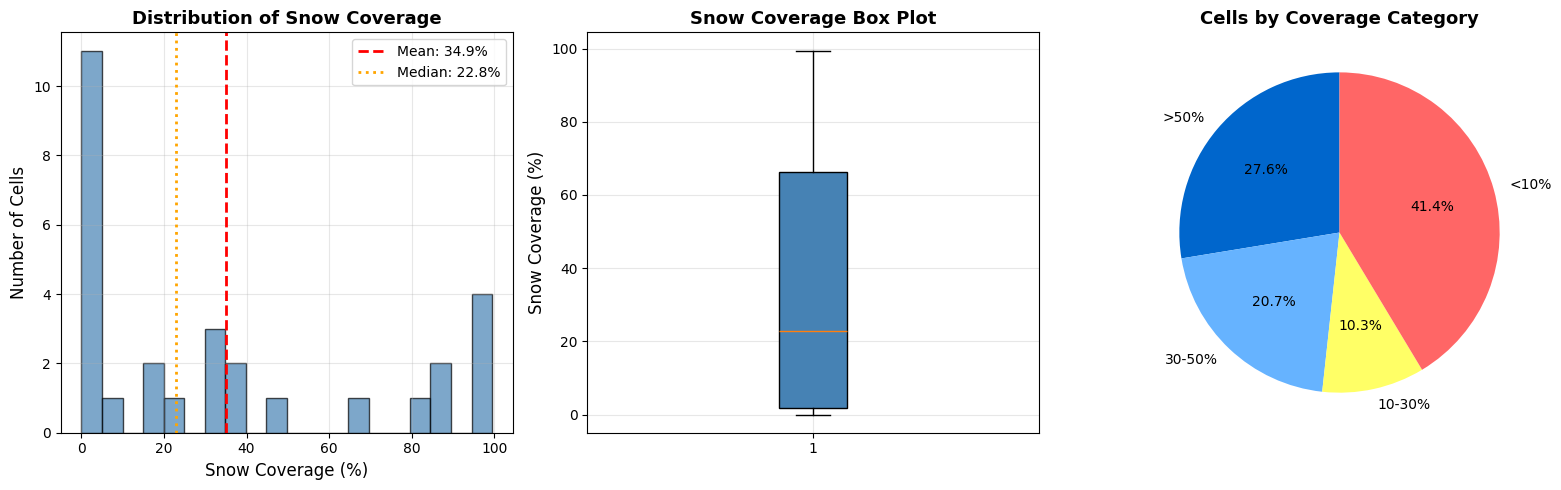


SUMMARY STATISTICS
  Count:   29 cells
  Mean:    34.94%
  Median:  22.79%
  Std Dev: 37.11%
  Min:     0.01%
  Max:     99.47%


In [8]:
# ======================================================================
# Visualization: Snow Coverage Distribution
# ======================================================================

if grid is not None and 'snow_percentage' in grid.columns:
    # Filter out None/NaN values
    valid_snow = grid['snow_percentage'].dropna()
    
    if len(valid_snow) > 0:
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        
        # Plot 1: Histogram
        axes[0].hist(valid_snow, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
        axes[0].axvline(valid_snow.mean(), color='red', linestyle='--', linewidth=2, 
                        label=f'Mean: {valid_snow.mean():.1f}%')
        axes[0].axvline(valid_snow.median(), color='orange', linestyle=':', linewidth=2,
                        label=f'Median: {valid_snow.median():.1f}%')
        axes[0].set_xlabel('Snow Coverage (%)', fontsize=12)
        axes[0].set_ylabel('Number of Cells', fontsize=12)
        axes[0].set_title('Distribution of Snow Coverage', fontsize=13, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Box plot
        bp = axes[1].boxplot(valid_snow, vert=True, patch_artist=True)
        bp['boxes'][0].set_facecolor('steelblue')
        axes[1].set_ylabel('Snow Coverage (%)', fontsize=12)
        axes[1].set_title('Snow Coverage Box Plot', fontsize=13, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        # Plot 3: Pie chart of coverage categories
        categories = {
            '>50%': (valid_snow >= 50).sum(),
            '30-50%': ((valid_snow >= 30) & (valid_snow < 50)).sum(),
            '10-30%': ((valid_snow >= 10) & (valid_snow < 30)).sum(),
            '<10%': (valid_snow < 10).sum()
        }
        colors = ['#0066cc', '#66b3ff', '#ffff66', '#ff6666']
        axes[2].pie(categories.values(), labels=categories.keys(), colors=colors,
                    autopct='%1.1f%%', startangle=90)
        axes[2].set_title('Cells by Coverage Category', fontsize=13, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics table
        print("\n" + "=" * 40)
        print("SUMMARY STATISTICS")
        print("=" * 40)
        print(f"  Count:   {len(valid_snow)} cells")
        print(f"  Mean:    {valid_snow.mean():.2f}%")
        print(f"  Median:  {valid_snow.median():.2f}%")
        print(f"  Std Dev: {valid_snow.std():.2f}%")
        print(f"  Min:     {valid_snow.min():.2f}%")
        print(f"  Max:     {valid_snow.max():.2f}%")
        print("=" * 40)
    else:
        print("No valid snow percentage data available.")
else:
    print("No grid data with snow_percentage column.")

## 7. Visualize NDSI Tiles

In [ ]:
# ======================================================================
# Visualization: NDSI Tiles
# ======================================================================

if HAS_RASTERIO and tile_dir.exists():
    tiles = sorted(tile_dir.glob("*.tif"))
    
    if tiles:
        print(f"Found {len(tiles)} NDSI tiles")
        
        # Show up to 9 tiles in a 3x3 grid
        n_show = min(9, len(tiles))
        cols = min(3, n_show)
        rows = (n_show + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
        if n_show == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        # Custom colormap for NDSI (-1 to 1)
        # Brown (no snow) -> Yellow -> Light blue -> Dark blue (snow/ice)
        colors = ['#8B4513', '#D2691E', '#F4A460', '#FFFFE0', '#87CEEB', '#4169E1', '#0000FF']
        ndsi_cmap = mcolors.LinearSegmentedColormap.from_list('ndsi', colors)
        
        for i, tile_path in enumerate(tiles[:n_show]):
            with rasterio.open(tile_path) as src:
                data = src.read(1)
                
                im = axes[i].imshow(data, cmap=ndsi_cmap, vmin=-1, vmax=1)
                cell_id = tile_path.stem.replace('ndsi_cell_', '')
                
                # Calculate snow percentage for this tile
                valid_data = data[~np.isnan(data)]
                if len(valid_data) > 0:
                    snow_pct = 100 * (valid_data >= 0.42).sum() / len(valid_data)
                    axes[i].set_title(f'Cell {cell_id}\nSnow: {snow_pct:.1f}%', fontsize=11)
                else:
                    axes[i].set_title(f'Cell {cell_id}', fontsize=11)
                axes[i].axis('off')
        
        # Add single colorbar
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('NDSI', fontsize=12)
        
        # Hide empty axes
        for j in range(n_show, len(axes)):
            axes[j].axis('off')
        
        plt.suptitle('NDSI Tiles\n(Blue = Snow/Ice, Brown = No Snow)', fontsize=14, fontweight='bold')
        plt.show()
    else:
        print("No NDSI tiles found in tile directory.")
else:
    if not HAS_RASTERIO:
        print("Install rasterio to visualize NDSI tiles: pip install rasterio")
    else:
        print("No tile directory found.")

No tile directory found.


In [ ]:
## 8. Load and Display Seed Points with Results

# ======================================================================
# Load Seed Points
# ======================================================================

seed_files = list(Path("data").glob("Iceland_Seeds*.geojson"))

if seed_files:
    print("Available seed files:")
    for i, sf in enumerate(seed_files):
        seeds_gdf = gpd.read_file(sf)
        print(f"  [{i}] {sf.name} - {len(seeds_gdf)} seed(s)")
    
    # Use the first seed file by default
    SEED_FILE = seed_files[0]
    seeds = gpd.read_file(SEED_FILE)
    print(f"\n✓ Loaded {len(seeds)} seeds from {SEED_FILE.name}")
else:
    seeds = None
    print("No seed files found in data/ directory")

In [ ]:
# ======================================================================
# Combined Map: Seeds + Processed Cells (Blue/Green style)
# ======================================================================

if grid is not None and seeds is not None:
    # Calculate center BEFORE converting to WGS84 (avoids centroid warning)
    center_point = grid.geometry.union_all().centroid
    center_gdf = gpd.GeoDataFrame(geometry=[center_point], crs=grid.crs)
    center_wgs84 = center_gdf.to_crs(epsg=4326)
    center_lat = center_wgs84.geometry.iloc[0].y
    center_lon = center_wgs84.geometry.iloc[0].x
    
    processed_grid_wgs84 = grid.to_crs(epsg=4326)
    seeds_wgs84 = seeds.to_crs(epsg=4326)
    initial_cells_wgs84 = initial_cells_gdf.to_crs(epsg=4326) if len(initial_cells_gdf) > 0 else None
    expansion_cells_wgs84 = expansion_cells_gdf.to_crs(epsg=4326) if len(expansion_cells_gdf) > 0 else None
    
    # Create map
    combined_map = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=8,
        tiles=None
    )
    
    # Add base layers
    folium.TileLayer('OpenStreetMap', name='OpenStreetMap').add_to(combined_map)
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Satellite'
    ).add_to(combined_map)
    
    # Add initial cells in blue (matches icland_ice_monitoring.ipynb)
    if initial_cells_wgs84 is not None and len(initial_cells_wgs84) > 0:
        folium.GeoJson(
            initial_cells_wgs84.__geo_interface__,
            name='Initial Cells (with seeds)',
            style_function=lambda x: {
                'fillColor': 'blue',
                'color': 'darkblue',
                'weight': 2.5,
                'fillOpacity': 0.4,
                'opacity': 0.7
            },
            tooltip=folium.GeoJsonTooltip(
                fields=['cell_id', 'snow_percentage'] if 'snow_percentage' in initial_cells_wgs84.columns else ['cell_id'],
                aliases=['Cell ID:', 'Snow %:'] if 'snow_percentage' in initial_cells_wgs84.columns else ['Cell ID:']
            )
        ).add_to(combined_map)
    
    # Add expansion cells in green
    if expansion_cells_wgs84 is not None and len(expansion_cells_wgs84) > 0:
        folium.GeoJson(
            expansion_cells_wgs84.__geo_interface__,
            name='Expansion Cells',
            style_function=lambda x: {
                'fillColor': 'lightgreen',
                'color': 'green',
                'weight': 2.5,
                'fillOpacity': 0.4,
                'opacity': 0.7
            },
            tooltip=folium.GeoJsonTooltip(
                fields=['cell_id', 'snow_percentage'] if 'snow_percentage' in expansion_cells_wgs84.columns else ['cell_id'],
                aliases=['Cell ID:', 'Snow %:'] if 'snow_percentage' in expansion_cells_wgs84.columns else ['Cell ID:']
            )
        ).add_to(combined_map)
    
    # Add seed points as RED markers (matches icland_ice_monitoring.ipynb)
    seed_group = folium.FeatureGroup(name='Glacier Seeds')
    for idx, row in seeds_wgs84.iterrows():
        if row.geometry.geom_type == 'Point':
            folium.CircleMarker(
                location=[row.geometry.y, row.geometry.x],
                radius=8,
                color='red',
                fill=True,
                fillColor='red',
                fillOpacity=0.8,
                popup=f"<b>Seed {idx}</b>",
                tooltip="Glacier Seed"
            ).add_to(seed_group)
    seed_group.add_to(combined_map)
    
    plugins.Fullscreen().add_to(combined_map)
    folium.LayerControl(collapsed=False).add_to(combined_map)
    
    print(f"✓ Combined map with {len(grid)} cells and {len(seeds)} seeds")
    print(f"  🔵 Blue: Initial cells (with seeds)")
    print(f"  🟢 Green: Expansion cells")
    print(f"  🔴 Red markers: Seed points")
    display(combined_map)
else:
    print("Missing grid or seed data.")

Missing grid or seed data.


## 9. Export Results

In [ ]:
# ======================================================================
# Export Map to HTML
# ======================================================================

if grid is not None and len(grid) > 0:
    # Export the main results map
    output_html = OUTPUT_DIR / "glacier_monitoring_map.html"
    map_results.save(str(output_html))
    print(f"✓ Results map saved to: {output_html}")
    
    # Also export combined map if seeds available
    if seeds is not None:
        combined_html = OUTPUT_DIR / "glacier_monitoring_combined_map.html"
        combined_map.save(str(combined_html))
        print(f"✓ Combined map saved to: {combined_html}")
    
    print("\nOpen these files in a web browser to view the interactive maps.")
else:
    print("No grid data to export.")

No grid data to export.


In [ ]:
# ======================================================================
# Generate Summary Report
# ======================================================================

if stats:
    config = stats.get('configuration', {})
    results = stats.get('results', {})
    
    report = f"""
================================================================================
                    GLACIER MONITORING SUMMARY REPORT
================================================================================

ANALYSIS PARAMETERS
-------------------
Date Range:        {config.get('date_start', 'N/A')} to {config.get('date_end', 'N/A')}
Grid Size:         {config.get('grid_size', 10000)} m ({config.get('grid_size', 10000)/1000:.0f} km)
NDSI Threshold:    {config.get('ndsi_threshold', 0.42)}
Snow Threshold:    {config.get('snow_percentage_threshold', 0.30)*100:.0f}%
Max Cloud Cover:   {config.get('max_cloud_cover', 50)}%
Max Iterations:    {config.get('max_iterations', 10)}

PROCESSING RESULTS
------------------
Initial Candidates: {results.get('initial_candidates', 0)}
Expansion Adds:     {results.get('expansion_added_cells', 0)}
Total Processed:    {results.get('total_cells_processed', 0)} cells
Iterations:         {results.get('iterations', 0)}

SNOW/ICE COVERAGE
-----------------
Snow/Ice Area:      {results.get('snow_ice_coverage_km2', 0):.2f} km²
Total Valid Area:   {results.get('total_valid_area_km2', 0):.2f} km²
Coverage:           {results.get('snow_ice_percentage', 0):.2f}%

PERFORMANCE
-----------
Processing Time:    {results.get('processing_time_formatted', 'N/A')}
Mode:               {results.get('mode', 'normal')}

================================================================================
"""
    print(report)
    
    # Save report to file
    report_path = OUTPUT_DIR / "summary_report.txt"
    with open(report_path, 'w') as f:
        f.write(report)
    print(f"✓ Report saved to: {report_path}")
else:
    print("No statistics available for report.")

No statistics available for report.
